In [ ]:
import torch, PIL
import matplotlib.pyplot as plt

from torchvision.transforms import Resize as tresize
from src.utils.metrics import parse_args
from src.utils.notebook import get_dataloaders, construct_a_star, get_dataset_file_names
from src.utils.training import set_global_seeds
from src.utils.viz import change_input_color, add_path, add_start_end_mark
from compute_hmean import get_methods

In [ ]:
def get_sample(config):
    set_global_seeds(config.seed)
    dataset_file_names = get_dataset_file_names(config)

    print(
        f"Dataset: {config.dataset_name}" \
        f", dataset files: {dataset_file_names}."
    )

    if config.dataset_name.find("sdd") > -1:
        sdd_test_scenes = config.sdd.test_scene_dict[config.sdd.test_scene_type]
        print(f"SDD test scenes: {sdd_test_scenes}.")
    else:
        sdd_test_scenes = [""]

    # Use the first one as an example
    dataset_file_name = dataset_file_names[0]
    test_scene = sdd_test_scenes[0]

    # Get the data loader
    config.dataset_file_name = dataset_file_name
    config.sdd.test_scene = test_scene

    data_loader = get_dataloaders(config, split="test")

    # Get a sample
    sample = next(iter(data_loader))

    start_maps = sample["starts"]
    num_starts = start_maps.shape[1]
    height, width = start_maps.shape[-2:]
    

    # Set starts in the batch for parallelization
    if num_starts > 1:
        for key in sample.keys():
            sample[key] = sample[key].view(-1, 1, height, width)

    return sample, config

@torch.no_grad()
def run_once(
    config,
    inputs
):
    # Get model with pretrained model
    # Inside construct_a_star, it invakes search_checkpoints(config) to find
    # the model path; thus, be aware of the folder structure of pretrained models.
    # Take the suggestion in README.md.
    # Otherwise, one can slightly change construct_a_star for a given model path.
    model = construct_a_star(config)

    g_ratio_v = model.astar.get_g_ratio()
    rotation_const_v = model.astar.get_rotation_const()
    rotation_weight_v = model.astar.get_rotation_weight()

    if isinstance(g_ratio_v, torch.Tensor): g_ratio_v = g_ratio_v.item()
    if isinstance(rotation_const_v, torch.Tensor): rotation_const_v = rotation_const_v.item()
    if isinstance(rotation_weight_v, torch.Tensor): rotation_weight_v = rotation_weight_v.item()

    # Set model status
    model.eval()

    # Run model, with outputs following AstarOutput in src/planner/differentiable_astar.py
    results, _ = model(
        inputs["maps"],
        inputs["starts"],
        inputs["goals"]
    )

    # Get results for visualzation
    paths = results.paths.detach().cpu()
    cost_maps = results.cost_maps.detach().cpu()
    path_angles = results.path_angles.detach().cpu()

    return {
        "paths": paths,
        "cost_maps": cost_maps,
        "path_angles": path_angles
    }

### Main Entry
Choose the dataset, the methods will be selected automatically.

In [3]:
# NOTE change the dataset and then re-run all the cells included and below
dataset_name = "sdd_inter"
assert dataset_name in ["mpd", "tmpd", "street", "aug_tmpd", "warcraft", "pkmn", "sdd_intra", "sdd_inter"]

In [ ]:
# Read initially
method = "daa_mix"
config_file_path = "config.yaml"
config = parse_args(config_file_path)
config.seed = 0
config.enable_resume = True
config.params.batch_size = 16

# Get sample
config = parse_args(config=config, dataset_name=dataset_name, method=method)
sample, config = get_sample(config)

# Get outputs for a method
methods = get_methods(dataset_name)
viz_dict = {
    "maps": sample["maps"],
    "starts": sample["starts"],
    "goals": sample["goals"],
    "solutions": {}
}

# Transfer data to GPU
for key in sample.keys():
    sample[key] = sample[key].cuda()

for method in methods:
    print(f"\n{'='*5} {method} {'='*5}")
    config = parse_args(config=config, method=method)
    outputs = run_once(config, sample)
    viz_dict["solutions"].update({method: {
        "paths": outputs["paths"],
        "cost_maps": outputs["cost_maps"]
    }})
    torch.cuda.empty_cache()

# Add reference
viz_dict["solutions"].update({"reference": {
    "paths": sample["optimal_paths"],
    "cost_maps": sample["ppm"].cpu() if "ppm" in sample.keys() else None
}})

### Visualization
Change the sample ID (sample_id) starting from 0. If it is out of the range of batch, the last sample will be shown. The batch size can be changed in the cell above.

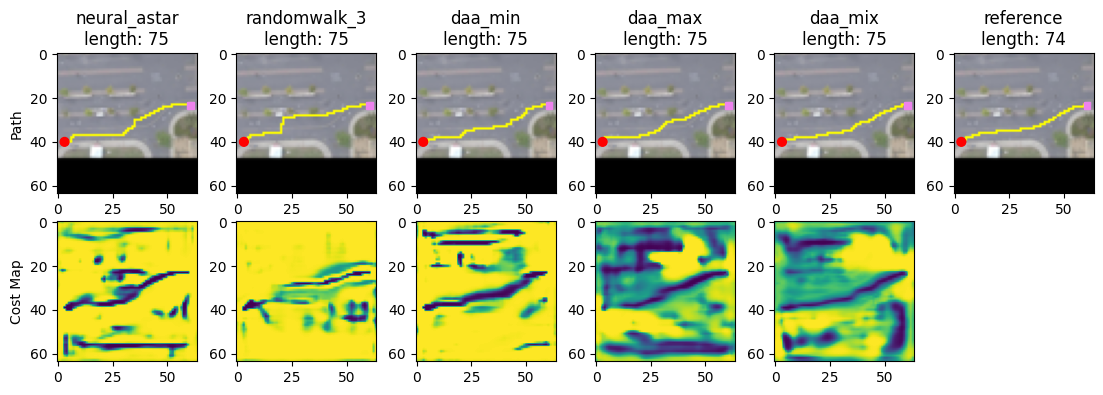

In [5]:
# Visualize
num_methods = len(viz_dict["solutions"])
fig = plt.figure(figsize=(18 * num_methods / 8, 4))
count = 1
sample_id = 0  # NOTE this can be changed and then re-run only this cell
num_samples = viz_dict["maps"].shape[0]
sample_id = min(sample_id, num_samples - 1)

for idx, method in enumerate(viz_dict["solutions"].keys()):
    solutions = viz_dict["solutions"][method]

    map = viz_dict["maps"][sample_id:sample_id + 1]
    start = viz_dict["starts"][sample_id:sample_id + 1]
    goal = viz_dict["goals"][sample_id:sample_id + 1]
    path = solutions["paths"][sample_id:sample_id + 1]
    num_steps = path.sum()

    if solutions["cost_maps"] is not None:
        cost_map = solutions["cost_maps"][sample_id:sample_id + 1]
    else:
        cost_map = None

    # Resize for visualization
    if map.shape[-1] != start.shape[-1]:
        img_h, img_w = map.shape[-2:]
        resize_obj = tresize((img_h, img_w), interpolation=PIL.Image.NEAREST)
        start = resize_obj(start)
        goal = resize_obj(goal)
        path = resize_obj(path)

        if cost_map is not None:
            cost_map = resize_obj(cost_map)

    # As map: batch*c*h*w
    if dataset_name == "aug_tmpd":
        map = 1 - map

        if method in ["reference", "transpath"]:
            cost_map = 1 - cost_map

    full = change_input_color(map)

    # As path: batch*h*w or batch*c*h*w
    full = add_path(full, path, mode='optimal')

    # Draw path
    axes_sub = fig.add_subplot(2, num_methods, count)

    # As start, goal: h*w, binary
    # Start circle, goal square
    add_start_end_mark(
        axes_sub,
        start.squeeze(),
        goal.squeeze(),
        fontsize=35
    )

    axes_sub.imshow(full.permute(0, 2, 3, 1).squeeze().numpy())
    if idx == 0: axes_sub.set_ylabel("Path")
    plt.title(f"{method}\nlength: {num_steps:.0f}")

    # Draw cost map
    if cost_map is not None:
        axes_sub = fig.add_subplot(2, num_methods, count + num_methods)
        axes_sub.imshow(cost_map.squeeze().numpy())
        if idx == 0: axes_sub.set_ylabel("Cost Map")

    count += 1